In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=conn)

In [10]:
inspector = inspect(engine)

In [11]:
columns = inspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(Measurement.date)).all()
max_date = datetime.strptime(max_date[0][0], '%Y-%m-%d').date()

year_ago = max_date - dt.timedelta(days=365)

print("max_date: ", max_date)  
print("year_ago: ", year_ago)              

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= year_ago, Measurement.prcp != None).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)
prcp_df.set_index("date", inplace=True)

# Sort the dataframe by date
prcp_df.sort_index(inplace=True)
prcp_df.head(7)

max_date:  2017-08-23
year_ago:  2016-08-23


,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
2016-08-23,1.79
2016-08-24,1.22


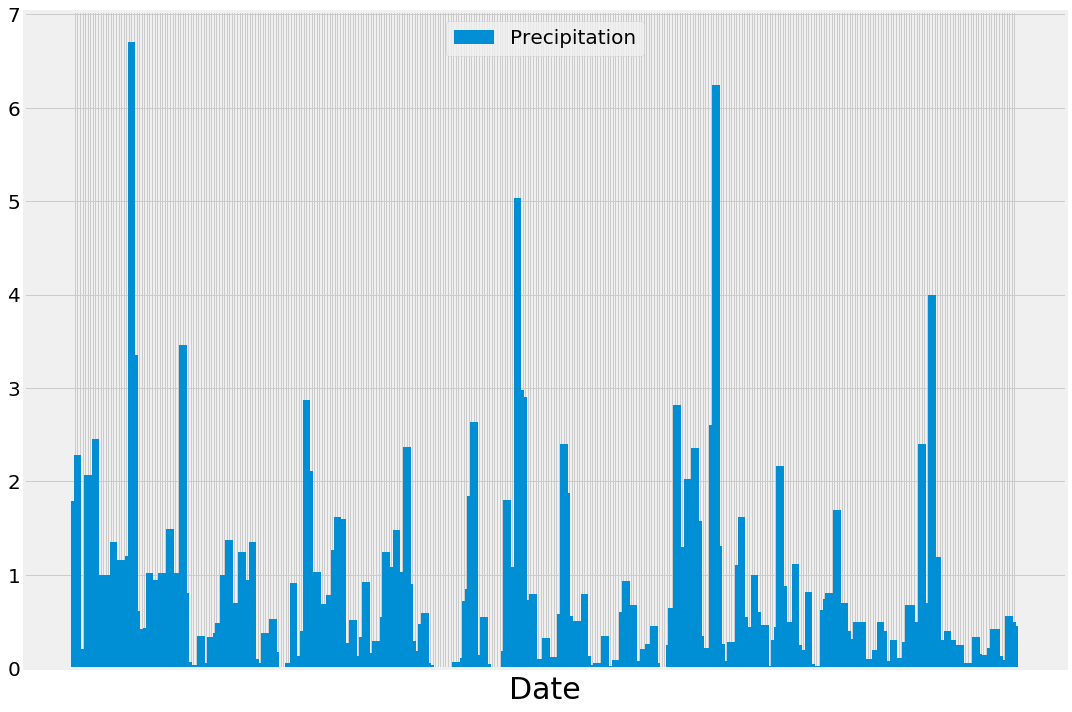

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15,10))
plt.bar(prcp_df.index.values, prcp_df["prcp"], label="Precipitation", tick_label="", width=3)

plt.xlabel("Date", fontsize=30)
plt.tick_params(labelsize=20)
plt.legend(loc="upper center", fontsize=20)

plt.tight_layout()
plt.savefig("./Images/PreciptationVsData.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
count_val = prcp_df["prcp"].count()
mean_val = prcp_df["prcp"].mean()
std_val = prcp_df["prcp"].std()
min_val = prcp_df["prcp"].min()
q_25 = prcp_df["prcp"].quantile(0.25)
q_50 = prcp_df["prcp"].quantile(0.50)
q_75 = prcp_df["prcp"].quantile(0.75)
max_val = prcp_df["prcp"].max()

Summary_Prcp = pd.DataFrame([{"count": count_val, "mean": mean_val, "std": std_val, "min": min_val, "25%": q_25,
                             "50%": q_50, "75%": q_75, "max": max_val}], 
                             columns=["count", "mean", "std", "min", "25%", "50%", "75%", "max"])
Summary_Prcp = Summary_Prcp.transpose()
Summary_Prcp.rename(columns={0: "precipitation"}, inplace=True)
Summary_Prcp

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.name.distinct())).all()
print(f"Number of Stations: {station_count[0][0]}")

Number of Stations: 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.station, func.count(Measurement.id).label("observation_count")).\
                        filter(Station.station == Measurement.station).group_by(Station.station).\
                        order_by(func.count(Measurement.prcp).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
#Setting the most_active_station value
most_active_station = active_stations[0][0]
most_active_station

'USC00519281'

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
most_active_station_data = session.query(*sel).filter(Measurement.station == most_active_station).all()

most_active_station_data

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_tmps = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date >= year_ago, Measurement.tobs != None, Measurement.station == most_active_station).\
            all()

tmps_df = pd.DataFrame(most_active_station_tmps)
tmps_df.set_index("date", inplace=True)
tmps_df.sort_index(inplace=True)
tmps_df.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


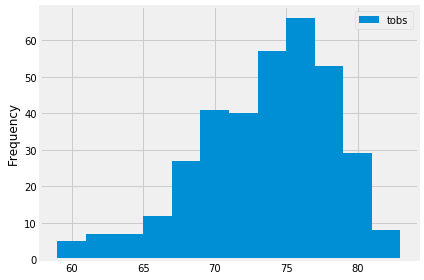

In [21]:
# Histogram for the past 12 months of the most active station
tmps_df.plot(kind="hist", bins=12)
plt.legend(loc="best")

plt.tight_layout()
plt.savefig("./Images/StationHistogram.png")
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps('2017-02-28', '2017-03-05')
tmin = trip_data[0][0]
tavg = trip_data[0][1]
tmax = trip_data[0][2]
trip_data[0]

(64.0, 72.02777777777777, 78.0)

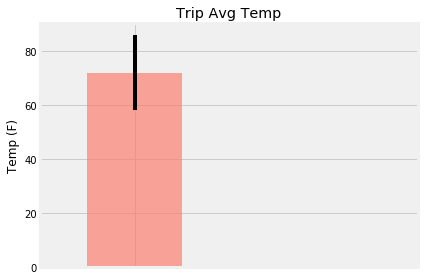

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1, tavg, yerr=(tmax-tmin), width=1, color="salmon", alpha=0.7, tick_label="")
plt.xlim(0, 4)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

plt.tight_layout()
plt.savefig("./Images/TripAvgTemp.png")
plt.show()

In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# This function called `calc_prcp` will accept start date and end date in the format '%Y-%m-%d' 
# and return the precipitation values for that range of dates per station
def calc_prcp(start_date, end_date=""):
    """precipitation, station, name, latitude, longitude, and elevation for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        precipitation, station, name, latitude, longitude, and elevation
    """
    if end_date=="":
        end_date = start_date
    
    sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, 
           Measurement.date, Measurement.prcp]
    result = session.query(*sel).filter(Measurement.date >= start_date, Measurement.date <= end_date).\
            filter(Station.station == Measurement.station, Measurement.prcp != None).\
            order_by(Measurement.date, Measurement.prcp.desc()).all()

    return result

#pd.DataFrame(calc_prcp('2017-02-28', '2017-03-05'))
pd.DataFrame(calc_prcp('2017-02-28'))

,station,name,latitude,longitude,elevation,date,prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2017-02-28,0.58
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2017-02-28,0.16
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2017-02-28,0.04
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2017-02-28,0.04
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2017-02-28,0.00
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2017-02-28,0.00


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = "2019-02-28"
end = "2019-03-05"
start_date = datetime.strptime(start, '%Y-%m-%d').date()
end_date = datetime.strptime(end, '%Y-%m-%d').date()

days_range = (end_date - start_date).days + 1

# Use the start and end date to create a range of dates
trip_dates = [(start_date + dt.timedelta(days=i)) for i in range(days_range)]

# Stip off the year and save a list of %m-%d strings
trip_mds = [(trip_date.strftime("%m-%d")) for trip_date in trip_dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[daily_normals(trip_md)[0] for trip_md in trip_mds]
normals

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"], index=pd.Index(trip_dates))
normals_df.index.name = "date"
normals_df

,tmin,tavg,tmax
date,,,
2019-02-28,65.0,70.655172,80.0
2019-03-01,64.0,70.032787,76.0
2019-03-02,61.0,70.366667,78.0
2019-03-03,60.0,70.068966,78.0
2019-03-04,57.0,69.272727,77.0
2019-03-05,60.0,67.890909,76.0


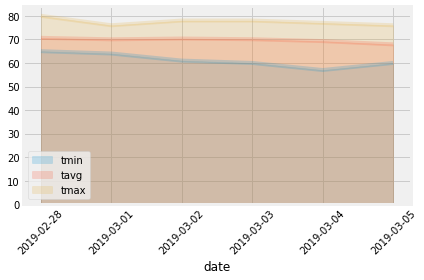

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area", stacked=False, alpha=0.2)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("./Images/DailyNormals.png")
plt.show()